# MODELOS DE REDES PARA DENGUE BARRANCABERMEJA

### Cargue de librerias requeridas

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

### Cargar la base de datos

In [2]:
datos = read_csv('Barrancabermeja_Lags.csv', encoding='latin-1', sep=";")

# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi',
       'Temp_Seca_Max_Dia_Prom', 'Temp_Seca_Max_Dia_Prom_1',
       'Temp_Seca_Max_Dia_Prom_2', 'Temp_Seca_Max_Dia_Prom_3',
       'Temp_Seca_Max_Dia_Prom_4', 'Temp_Seca_Max_Dia_Prom_5',
       'Temp_Seca_Max_Dia_Prom_6', 'Temp_Seca_Max_Sem', 'Temp_Seca_Max_Sem_1',
       'Temp_Seca_Max_Sem_2', 'Temp_Seca_Max_Sem_3', 'Temp_Seca_Max_Sem_4',
       'Temp_Seca_Max_Sem_5', 'Temp_Seca_Max_Sem_6', 'Temp_Seca_Min_Dia_Prom',
       'Temp_Seca_Min_Dia_Prom_1', 'Temp_Seca_Min_Dia_Prom_4',
       'Temp_Seca_Min_Dia_Prom_5', 'Temp_Seca_Min_Sem', 'Temp_Seca_Min_Sem_1', 'Temp_Seca_Min_Sem_2',
       'Temp_Seca_Min_Sem_3', 'Temp_Seca_Min_Sem_4', 'Temp_Seca_Min_Sem_5',
       'Temp_Seca_Min_Sem_6', 'Prom_Dia_Preci',
       'Prom_Dia_Preci_2', 'Prom_Dia_Preci_1', 'Prom_Dia_Preci_3',
       'Prom_Dia_Preci_4', 'Prom_Dia_Preci_5', 'Total_Preci_Sem',
        'Total_Preci_Sem_2', 'Total_Preci_Sem_1',
       'Total_Preci_Sem_3', 'Total_Preci_Sem_4', 'Total_Preci_Sem_5',
       'Temp_Max_Dia_Prom', 'Temp_Max_Dia_Prom_1', 'Temp_Max_Dia_Prom_2',
       'Temp_Max_Dia_Prom_3', 'Temp_Max_Dia_Prom_4', 'Temp_Max_Dia_Prom_5',
       'Temp_Max_Dia_Prom_6', 'Temp_Max_Sem', 'Temp_Max_Sem_1',
       'Temp_Max_Sem_2', 'Temp_Max_Sem_3', 'Temp_Max_Sem_4', 'Temp_Max_Sem_5',
       'Temp_Max_Sem_6', 'Temp_Min_Dia_Prom', 'Temp_Min_Dia_Prom_1',
       'Temp_Min_Dia_Prom_2', 'Temp_Min_Dia_Prom_3', 'Temp_Min_Dia_Prom_4',
       'Temp_Min_Dia_Prom_5', 'Temp_Min_Dia_Prom_6', 'Temp_Min_Sem',
       'Temp_Min_Sem_1', 'Temp_Min_Sem_2', 'Temp_Min_Sem_3', 'Temp_Min_Sem_4',
       'Temp_Min_Sem_5', 'Temp_Min_Sem_6', 'Hum_Rel_Max', 'Hum_Rel_Max_1',
       'Hum_Rel_Max_2', 'Hum_Rel_Max_3', 'Hum_Rel_Max_4', 'Hum_Rel_Max_5',
       'Hum_Rel_Max_6','Hum_Rel_Min_1', 'Hum_Rel_Min_2',
       'Hum_Rel_Min_3', 'Hum_Rel_Min_5','Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_6',
                    'Hum_Rel_Min', 'Hum_Rel_Min_6','Temp_Seca_Min_Dia_Prom_2', 'Hum_Rel_Min_4',  ],axis=1)
datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_6', 'Total_Preci_Sem_6'], dtype='object')

In [3]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_6     0
Total_Preci_Sem_6    0
dtype: int64

### División de los datos en set de entrenamiento y prueba

In [4]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [5]:
f_columns = ['Prom_Dia_Preci_6', 'Total_Preci_Sem_6']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [6]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# MODELO LSTM

In [8]:
# Creación de X_train, y_train, X_test y y_test Para el modelo LSTM

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_LSTM, y_train_LSTM = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_LSTM, y_test_LSTM = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_LSTM.shape, y_train_LSTM.shape, X_test_LSTM.shape, y_test_LSTM.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo LSTM

In [9]:
Preci_Barr_LSTM_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Preci_Barr_LSTM_model_1.add(keras.layers.InputLayer(input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    
#CAPAS INTERMEDIAS

Preci_Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Preci_Barr_LSTM_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Preci_Barr_LSTM_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Preci_Barr_LSTM_model_6.h5'
checkpoint_LSTM = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_LSTM = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_LSTM = Preci_Barr_LSTM_model_1.fit(X_train_LSTM,y_train_LSTM, validation_data=(X_test_LSTM,y_test_LSTM), 
                                     verbose=2, epochs=100, callbacks=[monitor_LSTM, checkpoint_LSTM])
Preci_Barr_LSTM_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 21s - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0218 - val_mse: 0.0218 - 21s/epoch - 2s/step
Epoch 2/100
14/14 - 1s - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0043 - val_mse: 0.0043 - 914ms/epoch - 65ms/step
Epoch 3/100
14/14 - 1s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0136 - val_mse: 0.0136 - 545ms/epoch - 39ms/step
Epoch 4/100
14/14 - 1s - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0057 - val_mse: 0.0057 - 559ms/epoch - 40ms/step
Epoch 5/100
14/14 - 1s - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0072 - val_mse: 0.0072 - 578ms/epoch - 41ms/step
Epoch 6/100
14/14 - 1s - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0053 - val_mse: 0.0053 - 553ms/epoch - 39ms/step
Epoch 7/100
14/14 - 1s - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0041 - val_mse: 0.0041 - 672ms/epoch - 48ms/step


# MODELO CNN

In [10]:
# Creación de X_train, y_train, X_test y y_test Para el modelo CNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_CNN, y_train_CNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_CNN, y_test_CNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_CNN.shape, y_train_CNN.shape, X_test_CNN.shape, y_test_CNN.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo CNN

In [11]:
Preci_Barr_CNN_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Preci_Barr_CNN_model_1.add(keras.layers.InputLayer(input_shape=(X_train_CNN.shape[1], X_train_CNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Preci_Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Preci_Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Preci_Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Preci_Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Preci_Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Preci_Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Preci_Barr_CNN_model_1.add(Dropout(0.5))
Preci_Barr_CNN_model_1.add(Flatten())
    
Preci_Barr_CNN_model_1.add(keras.layers.Dense(units=256, activation='linear'))
Preci_Barr_CNN_model_1.add(Dropout(0.5)) 


#CAPA DE SALIDA                 
Preci_Barr_CNN_model_1.add(Dense(1))


#COMPILACIÓN DEL MODELO
Preci_Barr_CNN_model_1.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Preci_Barr_CNN_model_6.h5'
checkpoint_CNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_CNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_CNN = Preci_Barr_CNN_model_1.fit(X_train_CNN,y_train_CNN, validation_data=(X_test_CNN,y_test_CNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_CNN, checkpoint_CNN])
Preci_Barr_CNN_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 3s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0156 - val_mse: 0.0156 - 3s/epoch - 228ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0049 - val_mse: 0.0049 - 292ms/epoch - 21ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0025 - val_mse: 0.0025 - 265ms/epoch - 19ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0035 - val_mse: 0.0035 - 241ms/epoch - 17ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0035 - val_mse: 0.0035 - 201ms/epoch - 14ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0027 - val_mse: 0.0027 - 201ms/epoch - 14ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0054 - val_mse: 0.0054 - 184ms/epoch - 13ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0028 - val_mse: 0.0028 - 192ms/epoch - 14ms/step


# MODELO RNN

In [12]:
# Creación de X_train, y_train, X_test y y_test Para el modelo RNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_RNN, y_train_RNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_RNN, y_test_RNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo RNN

In [13]:
Preci_Barr_RNN_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Preci_Barr_RNN_model_1.add(keras.layers.InputLayer(input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Preci_Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Preci_Barr_RNN_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Preci_Barr_RNN_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Preci_Barr_RNN_model_6.h5'
checkpoint_RNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_RNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_RNN = Preci_Barr_RNN_model_1.fit(X_train_RNN,y_train_RNN, validation_data=(X_test_RNN,y_test_RNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_RNN, checkpoint_RNN])
Preci_Barr_RNN_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 10s - loss: 0.0441 - mse: 0.0441 - val_loss: 0.0111 - val_mse: 0.0111 - 10s/epoch - 747ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0044 - val_mse: 0.0044 - 385ms/epoch - 27ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0075 - val_mse: 0.0075 - 272ms/epoch - 19ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0071 - val_mse: 0.0071 - 257ms/epoch - 18ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0074 - val_mse: 0.0074 - 256ms/epoch - 18ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0073 - val_mse: 0.0073 - 256ms/epoch - 18ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0046 - val_mse: 0.0046 - 256ms/epoch - 18ms/step


# MODELO GRU

In [14]:
# Creación de X_train, y_train, X_test y y_test Para el modelo GRU

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_GRU, y_train_GRU = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_GRU, y_test_GRU = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_GRU.shape, y_train_GRU.shape, X_test_GRU.shape, y_test_GRU.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo GRU

In [15]:
Preci_Barr_GRU_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Preci_Barr_GRU_model_1.add(keras.layers.InputLayer(input_shape=(X_train_GRU.shape[1], X_train_GRU.shape[2])))
    
    
#CAPAS INTERMEDIAS

Preci_Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Preci_Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Preci_Barr_GRU_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Preci_Barr_GRU_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Preci_Barr_GRU_model_6.h5'
checkpoint_GRU = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_GRU = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_GRU = Preci_Barr_GRU_model_1.fit(X_train_GRU,y_train_GRU, validation_data=(X_test_GRU,y_test_GRU), 
                                     verbose=2, epochs=100, callbacks=[monitor_GRU, checkpoint_GRU])
Preci_Barr_GRU_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 20s - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0067 - val_mse: 0.0067 - 20s/epoch - 1s/step
Epoch 2/100
14/14 - 1s - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0122 - val_mse: 0.0122 - 537ms/epoch - 38ms/step
Epoch 3/100
14/14 - 1s - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0070 - val_mse: 0.0070 - 633ms/epoch - 45ms/step
Epoch 4/100
14/14 - 1s - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0070 - val_mse: 0.0070 - 537ms/epoch - 38ms/step
Epoch 5/100
14/14 - 1s - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0035 - val_mse: 0.0035 - 633ms/epoch - 45ms/step
Epoch 6/100
14/14 - 1s - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0038 - val_mse: 0.0038 - 529ms/epoch - 38ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0038 - val_mse: 0.0038 - 489ms/epoch - 35ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0107 - val_mse: 0.0107 - 497ms/epoch - 35ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0055 - val_mse: 0

### Graficas de función de pérdida & RMSE

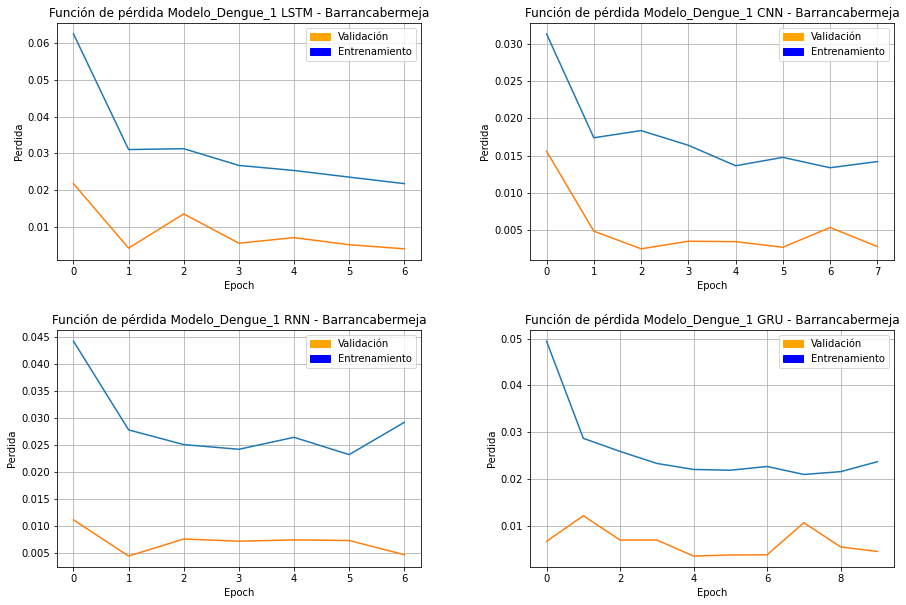

In [16]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 LSTM - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

plt.subplot(2, 2, 2)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 CNN - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])

plt.subplot(2, 2, 3)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 RNN - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])

plt.subplot(2, 2, 4)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 GRU - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])

plt.show()

# Gráficas de dispersión

6/6 [==============================] - 3s 14ms/step


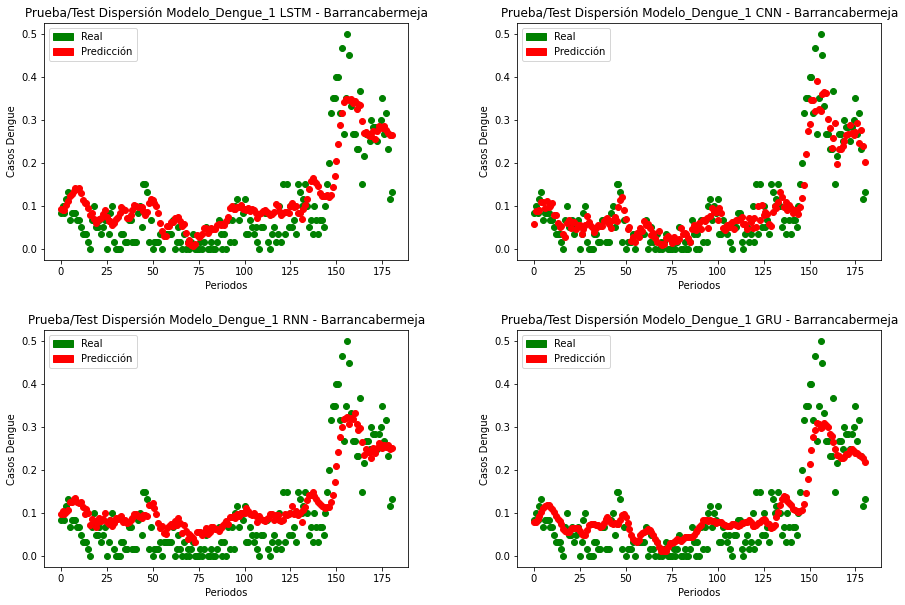

In [17]:
results_LSTM =Preci_Barr_LSTM_model_1.predict(X_test_LSTM)
results_CNN =Preci_Barr_CNN_model_1.predict(X_test_CNN)
results_RNN =Preci_Barr_RNN_model_1.predict(X_test_RNN)
results_GRU =Preci_Barr_GRU_model_1.predict(X_test_GRU)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 LSTM - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_LSTM)),y_test_LSTM,c='g')
plt.scatter(range(len(results_LSTM)),results_LSTM,c='r')

plt.subplot(2, 2, 2)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 CNN - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_CNN)),y_test_CNN,c='g')
plt.scatter(range(len(results_CNN)),results_CNN,c='r')

plt.subplot(2, 2, 3)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 RNN - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_RNN)),y_test_RNN,c='g')
plt.scatter(range(len(results_RNN)),results_RNN,c='r')

plt.subplot(2, 2, 4)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 GRU - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_GRU)),y_test_GRU,c='g')
plt.scatter(range(len(results_GRU)),results_GRU,c='r')

plt.show()

In [18]:
y_pred_LSTM = Preci_Barr_LSTM_model_1.predict(X_test_LSTM)
y_pred_CNN = Preci_Barr_CNN_model_1.predict(X_test_CNN)
y_pred_RNN = Preci_Barr_RNN_model_1.predict(X_test_RNN)
y_pred_GRU = Preci_Barr_GRU_model_1.predict(X_test_GRU)

y_train_inv_LSTM = dengue_transformer.inverse_transform(y_train_LSTM.reshape(1, -1))
y_train_inv_CNN = dengue_transformer.inverse_transform(y_train_CNN.reshape(1, -1))
y_train_inv_RNN = dengue_transformer.inverse_transform(y_train_RNN.reshape(1, -1))
y_train_inv_GRU = dengue_transformer.inverse_transform(y_train_GRU.reshape(1, -1))

y_test_inv_LSTM = dengue_transformer.inverse_transform(y_test_LSTM.reshape(1, -1))
y_test_inv_CNN = dengue_transformer.inverse_transform(y_test_CNN.reshape(1, -1))
y_test_inv_RNN = dengue_transformer.inverse_transform(y_test_RNN.reshape(1, -1))
y_test_inv_GRU = dengue_transformer.inverse_transform(y_test_GRU.reshape(1, -1))

y_pred_inv_LSTM = dengue_transformer.inverse_transform(y_pred_LSTM)
y_pred_inv_CNN = dengue_transformer.inverse_transform(y_pred_CNN)
y_pred_inv_RNN = dengue_transformer.inverse_transform(y_pred_RNN)
y_pred_inv_GRU = dengue_transformer.inverse_transform(y_pred_GRU)

6/6 [==============================] - 0s 12ms/step


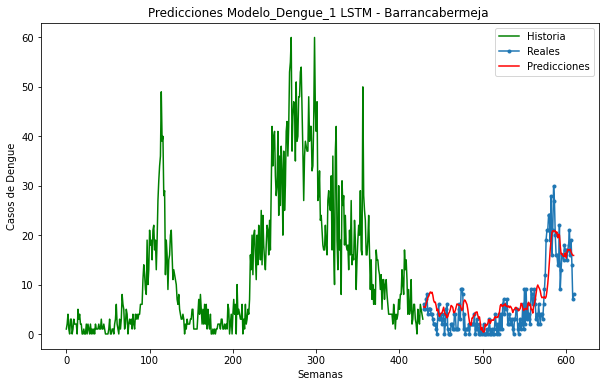

In [19]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_LSTM)), y_train_inv_LSTM.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_test_inv_LSTM.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_pred_inv_LSTM.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 LSTM - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

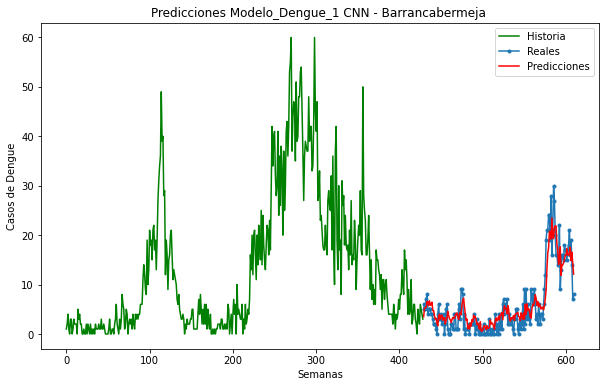

In [20]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_CNN)), y_train_inv_CNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_test_inv_CNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_pred_inv_CNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 CNN - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

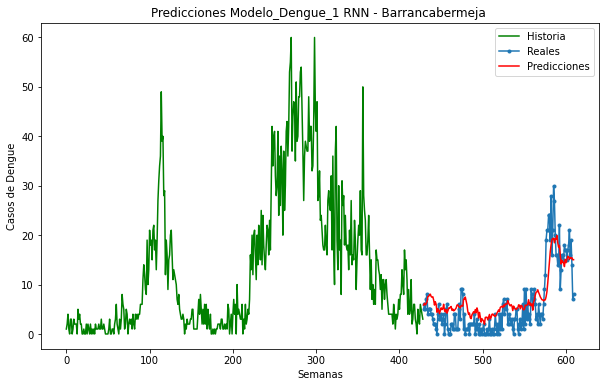

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_RNN)), y_train_inv_RNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_test_inv_RNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_pred_inv_RNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 RNN - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

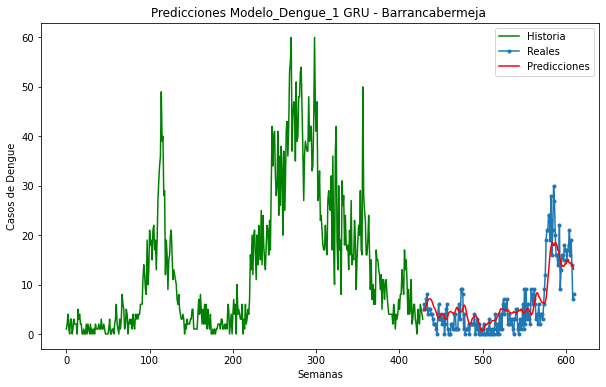

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_GRU)), y_train_inv_GRU.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_test_inv_GRU.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_pred_inv_GRU.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 GRU - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

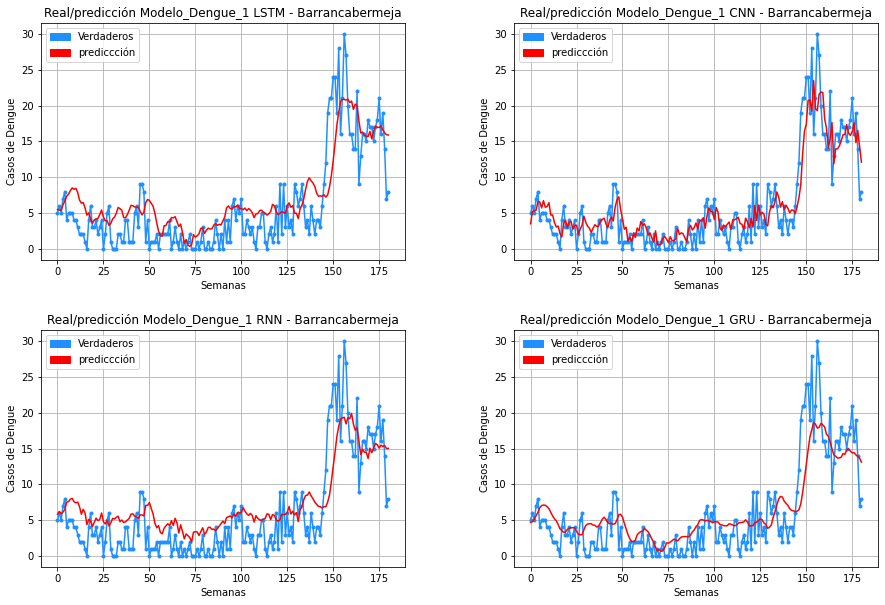

In [23]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Real/predicción Modelo_Dengue_1 LSTM - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_LSTM.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_LSTM.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Real/predicción Modelo_Dengue_1 CNN - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_CNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_CNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Real/predicción Modelo_Dengue_1 RNN - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_RNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_RNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Real/predicción Modelo_Dengue_1 GRU - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_GRU.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_GRU.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.show()

In [24]:
score_LSTM = np.sqrt(metrics.mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
score_CNN = np.sqrt(metrics.mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
score_RNN = np.sqrt(metrics.mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
score_GRU = np.sqrt(metrics.mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

print("RMSE Modelo LSTM Dengue Barranca : {}".format(score_LSTM))
print("RMSE Modelo CNN Dengue Barranca  : {}".format(score_CNN))
print("RMSE Modelo RNN Dengue Barranca  : {}".format(score_RNN))
print("RMSE Modelo GRU Dengue Barranca  : {}".format(score_GRU))

RMSE Modelo LSTM Dengue Barranca : 3.8646724666233703
RMSE Modelo CNN Dengue Barranca  : 2.9971572870846552
RMSE Modelo RNN Dengue Barranca  : 3.969672997836111
RMSE Modelo GRU Dengue Barranca  : 3.5716884897537438


In [25]:
print("MSE Modelo LSTM Dengue Barranca  = ", mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MSE Modelo CNN Dengue Barranca   = ", mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MSE Modelo RNN Dengue Barranca   = ", mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MSE Modelo GRU Dengue Barranca   = ", mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MSE Modelo LSTM Dengue Barranca  =  14.935693274276764
MSE Modelo CNN Dengue Barranca   =  8.98295180352465
MSE Modelo RNN Dengue Barranca   =  15.75830370974914
MSE Modelo GRU Dengue Barranca   =  12.75695866783938


In [26]:
print("MAE Modelo LSTM Dengue Barranca = ", mean_absolute_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MAE Modelo CNN Dengue Barranca  = ", mean_absolute_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MAE Modelo RNN Dengue Barranca  = ", mean_absolute_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MAE Modelo GRU Dengue Barranca  = ", mean_absolute_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MAE Modelo LSTM Dengue Barranca =  3.039793309091863
MAE Modelo CNN Dengue Barranca  =  2.2879951928860573
MAE Modelo RNN Dengue Barranca  =  3.237587604074847
MAE Modelo GRU Dengue Barranca  =  2.741872691976431


In [27]:
print("r2_score Modelo LSTM Dengue Barranca  = ", r2_score(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("r2_score Modelo CNN Dengue Barranca  = ", r2_score(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("r2_score Modelo RNN Dengue Barranca  = ", r2_score(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("r2_score Modelo GRU Dengue Barranca  = ", r2_score(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

r2_score Modelo LSTM Dengue Barranca  =  0.6574042650044454
r2_score Modelo CNN Dengue Barranca  =  0.7939485687712615
r2_score Modelo RNN Dengue Barranca  =  0.6385351826270611
r2_score Modelo GRU Dengue Barranca  =  0.7073801964959021


In [28]:
print("explained_variance_score Modelo LSTM Dengue Barranca  = ", explained_variance_score(y_test_inv_LSTM.flatten(), 
                                                                                           y_pred_inv_LSTM.flatten()))
print("explained_variance_score Modelo CNN Dengue Barranca  = ", explained_variance_score(y_test_inv_CNN.flatten(), 
                                                                                           y_pred_inv_CNN.flatten()))
print("explained_variance_score Modelo RNN Dengue Barranca  = ", explained_variance_score(y_test_inv_RNN.flatten(), 
                                                                                           y_pred_inv_RNN.flatten()))
print("explained_variance_score Modelo GRU Dengue Barranca  = ", explained_variance_score(y_test_inv_GRU.flatten(), 
                                                                                           y_test_inv_GRU.flatten()))

explained_variance_score Modelo LSTM Dengue Barranca  =  0.7010797781841835
explained_variance_score Modelo CNN Dengue Barranca  =  0.7962600154831656
explained_variance_score Modelo RNN Dengue Barranca  =  0.6867805597543147
explained_variance_score Modelo GRU Dengue Barranca  =  1.0


### VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

In [29]:
#MODELO LSTM
resultados_LSTM = pd.DataFrame({ 'Actuales':y_test_inv_LSTM.flatten(), 'Predicciones': y_pred_inv_LSTM.flatten()})
resultados_LSTM['diferencia'] = resultados_LSTM['Predicciones'] - resultados_LSTM['Actuales']
print(resultados_LSTM.head(5))
print(resultados_LSTM.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      5.499829    0.499829
1       6.0      5.398416   -0.601584
2       5.0      5.383255    0.383255
3       7.0      6.161990   -0.838010
4       8.0      6.657988   -1.342012
     Actuales  Predicciones  diferencia
176      16.0     17.159624    1.159624
177      19.0     16.600508   -2.399492
178      14.0     16.178953    2.178953
179       7.0     15.927399    8.927399
180       8.0     15.893279    7.893279


In [30]:
#MODELO CNN
resultados_CNN = pd.DataFrame({ 'Actuales':y_test_inv_CNN.flatten(), 'Predicciones': y_pred_inv_CNN.flatten()})
resultados_CNN['diferencia'] = resultados_CNN['Predicciones'] - resultados_CNN['Actuales']
print(resultados_CNN.head(5))
print(resultados_CNN.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      3.489414   -1.510586
1       6.0      5.219779   -0.780221
2       5.0      5.266529    0.266529
3       7.0      5.396321   -1.603679
4       8.0      6.585133   -1.414867
     Actuales  Predicciones  diferencia
176      16.0     17.543835    1.543835
177      19.0     14.827182   -4.172818
178      14.0     16.534843    2.534843
179       7.0     14.304025    7.304025
180       8.0     12.101558    4.101558


In [31]:
#MODELO RNN
resultados_RNN = pd.DataFrame({ 'Actuales':y_test_inv_RNN.flatten(), 'Predicciones': y_pred_inv_RNN.flatten()})
resultados_RNN['diferencia'] = resultados_RNN['Predicciones'] - resultados_RNN['Actuales']
print(resultados_RNN.head(5))
print(resultados_RNN.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      5.839187    0.839187
1       6.0      6.223775    0.223775
2       5.0      5.889274    0.889274
3       7.0      6.140897   -0.859103
4       8.0      6.497800   -1.502200
     Actuales  Predicciones  diferencia
176      16.0     15.489509   -0.510491
177      19.0     15.294559   -3.705441
178      14.0     15.445760    1.445760
179       7.0     15.005043    8.005043
180       8.0     15.036174    7.036174


In [32]:
#MODELO GRU
resultados_GRU = pd.DataFrame({ 'Actuales':y_test_inv_GRU.flatten(), 'Predicciones': y_pred_inv_GRU.flatten()})
resultados_GRU['diferencia'] = resultados_GRU['Predicciones'] - resultados_GRU['Actuales']
print(resultados_GRU.head(5))
print(resultados_GRU.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      4.703067   -0.296933
1       6.0      4.813356   -1.186644
2       5.0      5.118685    0.118685
3       7.0      5.632664   -1.367336
4       8.0      6.101827   -1.898173
     Actuales  Predicciones  diferencia
176      16.0     14.434406   -1.565594
177      19.0     14.128547   -4.871453
178      14.0     13.957835   -0.042165
179       7.0     13.683931    6.683931
180       8.0     13.105302    5.105302
